## Avaliação em holdouts - Amazon Kindle

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore, EvalPrequential # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Amazon Kindle
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [4]:
# importa dataset 'books playlists'
data = pd.read_csv('output/amazonkindle_dump/2nd_sampled_amazon_kindle.csv')
dataset_name = 'Amazon_Kindle'
user_col = 'user_id'
item_col = 'item_id'

In [5]:
data.shape, data.user_id.nunique(), data.item_id.nunique()

((77145, 4), 13902, 59197)

In [6]:
data[['user_id', 'item_id']].duplicated().sum()

363

In [7]:
data.head()

,user_id,item_id,timestamp,date
0,B000FA5PV4,A23NR7891PY2P1,1388534400,2014-01-01
1,B000FC1LLA,A1CBHVD1PG6UUV,1388534400,2014-01-01
2,B000GFK7L6,ARISSM47DJHQ8,1388534400,2014-01-01
3,B000QCS8YM,A1SBCP7BB2QK9T,1388534400,2014-01-01
4,B000VDUWMC,ABSBO832VAJ36,1388534400,2014-01-01


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77145 entries, 0 to 77144
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    77145 non-null  object
 1   item_id    77145 non-null  object
 2   timestamp  77145 non-null  int64 
 3   date       77145 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.4+ MB


### Convert timestamp

In [9]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: user 718 ms, sys: 0 ns, total: 718 ms
Wall time: 2.65 s


In [10]:
data.head()

,user_id,item_id,timestamp,date
0,B000FA5PV4,A23NR7891PY2P1,1388534400,2014-01-01
1,B000FC1LLA,A1CBHVD1PG6UUV,1388534400,2014-01-01
2,B000GFK7L6,ARISSM47DJHQ8,1388534400,2014-01-01
3,B000QCS8YM,A1SBCP7BB2QK9T,1388534400,2014-01-01
4,B000VDUWMC,ABSBO832VAJ36,1388534400,2014-01-01


In [11]:
data.tail()

,user_id,item_id,timestamp,date
77140,B017R65QS0,A324LH5GJ25AGN,1393545600,2014-02-01
77141,B017R65QS0,A3SYMLOGJ05LLN,1393545600,2014-02-01
77142,B0183G04SU,A2UOPNVOWI5KTE,1393545600,2014-02-01
77143,B01BA56KLQ,A1HTKMB00WLD6H,1393545600,2014-02-01
77144,B01BA56KLQ,A1NO8K23DF6FYM,1393545600,2014-02-01


CPU times: user 79.8 ms, sys: 7.94 ms, total: 87.8 ms
Wall time: 381 ms


Text(0.5, 1.0, 'interactions per month')

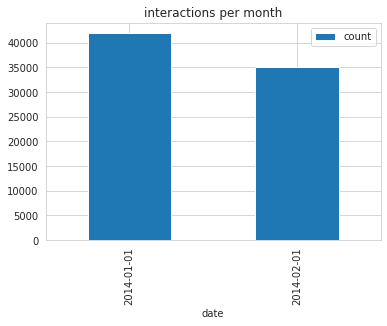

In [12]:
%%time
# 198ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month')

___
## Get intervals and Frequent users (threshold = 0.75)

time intervals

In [12]:
user_presence_df = pd.read_csv('output/amazonkindle_dump/2nd_sample_user_presence_df.csv')
user_month_interactions = pd.read_csv('output/amazonkindle_dump/2nd_sample_user_month_interactions.csv')
frequent_users_month = joblib.load('output/amazonkindle_dump/2nd_sample_frequent_users_month.joblib')

___
## Experiments using months

In [13]:
data.shape

(77145, 4)

In [14]:
%%time
# 8min 30s
buckets, holdouts = getBucketsHoldouts(
    data=data, # data[ data['date'].dt.month == 1 ],#
    user_col=user_col,
    item_col=item_col,
    frequent_users=data['user_id'].unique(), #frequent_users_month, # for every user in holdout: data['user_id'].unique()
    interval_type='M',
    intervals=None, 
    cold_start_buckets=0)

Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between holdout 1 and all buckets: 39
common interactions between holdout 2 and all buckets: 36
Converting to ImplicitData. . .
Done!
CPU times: user 1min 50s, sys: 209 ms, total: 1min 51s
Wall time: 5min 13s


In [15]:
sum( [b.size for b in buckets] ) + sum( [h.size for h in holdouts] )

77145

In [16]:
joblib.dump(buckets, 'output/amazonkindle_dump/2nd_sample_buckets.joblib')
joblib.dump(holdouts, 'output/amazonkindle_dump/2nd_sample_holdouts.joblib')

['output/amazonkindle_dump/2nd_sample_holdouts.joblib']

### ISGD

In [14]:
buckets = joblib.load('output/amazonkindle_dump/2nd_sample_buckets.joblib')
holdouts = joblib.load('output/amazonkindle_dump/2nd_sample_holdouts.joblib')

In [15]:
[(b.size, len(b.userset), len(b.itemset)) for b in buckets]

[(35763, 10295, 29769), (27265, 7296, 22764)]

In [16]:
[(b.size, len(b.userset), len(b.itemset)) for b in holdouts]

[(6231, 6231, 5638), (7886, 7886, 7043)]

Hyperparameters

In [17]:
%%time
import itertools
def grid_search(model, stream, random_seed = 10, interleaved=10):    
    num_factors = [100, 150, 200]
    num_iter = [2, 5, 8]
    learn_rate = [0.1, 0.25, 0.5]
    regularization = [0.3, 0.4, 0.5]
    num_nodes = [4, 8, 16]
    grid = [num_factors, num_iter, learn_rate, regularization, num_nodes]
    grid = list(itertools.product(*grid))
    results = []
    for i, hp in enumerate(grid):
        print(((i*100)/len(grid)), '%')
        empty_stream = ImplicitData([], [])
        nf, ni, lr, reg, nn = hp
        m = model(empty_stream, nf, ni, lr, reg, reg, random_seed)
        e = EvalPrequential(m, stream, metrics = ["Recall@N"])
        result = e.Evaluate(start_eval=0, count=stream.size, interleaved=interleaved)
        results.append( np.mean(result['Recall@N']) )
    return grid, results    

# OPTIONAL FOR NOW
prop = 0.05
hp_sample = data.iloc[:round( data.shape[0]*prop )]
stream = ImplicitData(hp_sample[user_col], hp_sample[item_col]) #(data['playlist_id'],data['track_id'])    
grid, results = grid_search(model=ISGD, stream=stream, random_seed=10, interleaved=1 )
len(grid), len(results), max(results) # (243, 243, 0.003461128860489883)

0.0 %
0.411522633744856 %
0.823045267489712 %
1.2345679012345678 %
1.646090534979424 %
2.05761316872428 %
2.4691358024691357 %
2.880658436213992 %
3.292181069958848 %
3.7037037037037037 %
4.11522633744856 %
4.526748971193416 %
4.938271604938271 %
5.349794238683128 %
5.761316872427984 %
6.172839506172839 %
6.584362139917696 %
6.995884773662551 %
7.407407407407407 %
7.818930041152264 %
8.23045267489712 %
8.641975308641975 %
9.053497942386832 %
9.465020576131687 %
9.876543209876543 %
10.2880658436214 %
10.699588477366255 %
11.11111111111111 %
11.522633744855968 %
11.934156378600823 %
12.345679012345679 %
12.757201646090534 %
13.168724279835391 %
13.580246913580247 %
13.991769547325102 %
14.40329218106996 %
14.814814814814815 %
15.22633744855967 %
15.637860082304528 %
16.049382716049383 %
16.46090534979424 %
16.872427983539094 %
17.28395061728395 %
17.695473251028808 %
18.106995884773664 %
18.51851851851852 %
18.930041152263374 %
19.34156378600823 %
19.753086419753085 %
20.16460905349794 %

/home/kpereira/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:113: RuntimeWarning: invalid value encountered in add
  p_u += delta
/home/kpereira/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:112: RuntimeWarning: overflow encountered in multiply
  delta = self.learn_rate * (err * q_i - self.user_regularization * p_u)
/home/kpereira/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:119: RuntimeWarning: overflow encountered in multiply
  delta = self.learn_rate * (err * p_u - self.item_regularization * q_i)
/home/kpereira/streamRec-forgetting/notebooks/../recommenders_implicit/ISGD.py:119: RuntimeWarning: invalid value encountered in subtract
  delta = self.learn_rate * (err * p_u - self.item_regularization * q_i)


85.59670781893004 %
86.0082304526749 %
86.41975308641975 %
86.83127572016461 %
87.24279835390946 %
87.65432098765432 %
88.06584362139918 %
88.47736625514403 %
88.88888888888889 %
89.30041152263375 %
89.7119341563786 %
90.12345679012346 %
90.53497942386831 %
90.94650205761317 %
91.35802469135803 %
91.76954732510288 %
92.18106995884774 %
92.5925925925926 %
93.00411522633745 %
93.4156378600823 %
93.82716049382717 %
94.23868312757202 %
94.65020576131687 %
95.06172839506173 %
95.47325102880659 %
95.88477366255144 %
96.29629629629629 %
96.70781893004116 %
97.11934156378601 %
97.53086419753086 %
97.94238683127573 %
98.35390946502058 %
98.76543209876543 %
99.17695473251028 %
99.58847736625515 %
CPU times: user 4h 16min 30s, sys: 11h 33min 11s, total: 15h 49min 41s
Wall time: 3h 21min 39s


(243, 243, 0.003461128860489883)

In [20]:
# num_factors, num_iter, learn_rate, regularization, num_nodes = grid[ np.argmax( results ) ]
num_factors, num_iter, learn_rate, regularization, num_nodes = grid[ np.argmax( results ) ] # (100, 8, 0.5, 0.3, 4)

#  OLD
# define hyperparameters (SAME AS LASTFM) ????
# num_factors = 160
# num_iter = 4
# learn_rate = 0.5
# regularization = 0.4
# num_nodes = 8

In [21]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [22]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

In [23]:
%%time
# 8h 31min 2s
eval.Train_Evaluate(N_recommendations=20, exclude_known_items=True, default_user='none')

----------------------------------------------------------------------------------------------------
Train bucket 0
Test Holdout 0
Test Holdout 1
recommendations not made for users in holdout 1 x checkpoint 0: 1767
----------------------------------------------------------------------------------------------------
Train bucket 1
Test Holdout 0
Test Holdout 1
CPU times: user 2h 24min 29s, sys: 3h 40min 25s, total: 6h 4min 54s
Wall time: 2h 6min 15s


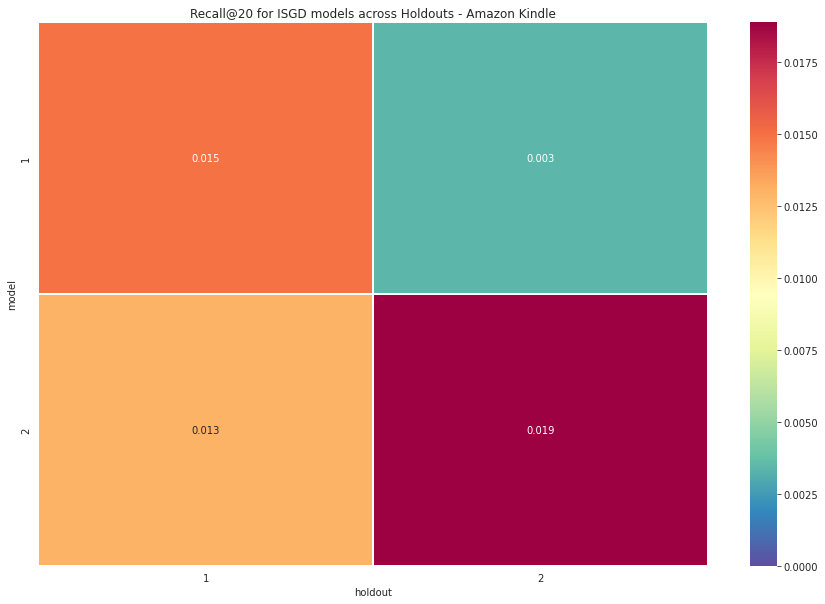

In [25]:
#0.0 freq T
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD results.csv', index=False)

recall_heatmap(df,
               round_point=3,
               title='Recall@20 for ISGD models across Holdouts - Amazon Kindle',
               filepath='images/heatmaps/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [26]:
arecall = avg_recall(df)
arecall

0.016909808048269935

In [27]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-0.0019258545979778524], -0.0019258545979778524)

In [28]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.003431933322438307

In [29]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD eval time.joblib')

['output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD eval time.joblib']